## Employee attrition


### Import packages

In [3]:
# required packages
# install vip from github repo: devtools::install_github("koalaverse/vip")
library(lime)       # ML local interpretation
library(vip)        # ML global interpretation
library(pdp)        # ML global interpretation
library(ggplot2)    # visualization pkg leveraged by above packages
library(caret)      # ML model building
library(h2o)        # ML model building

In [4]:
# initialize h2o
h2o.init()

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         9 seconds 837 milliseconds 
    H2O cluster timezone:       Europe/Berlin 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.22.1.1 
    H2O cluster version age:    2 months and 4 days  
    H2O cluster name:           H2O_started_from_R_krish_czf434 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   4.00 GB 
    H2O cluster total cores:    12 
    H2O cluster allowed cores:  12 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.5.2 (2018-12-20) 



In [5]:
# create data sets
df <- rsample::attrition %>% 
  dplyr::mutate_if(is.ordered, factor, ordered = FALSE) %>%
  dplyr::mutate(Attrition = factor(Attrition, levels = c("Yes", "No")))

In [6]:
index <- 1:5
train_obs <- df[-index, ]
local_obs <- df[index, ]

In [7]:
# create h2o objects for modeling
y <- "Attrition"
x <- setdiff(names(train_obs), y)
train_obs.h2o <- as.h2o(train_obs)
local_obs.h2o <- as.h2o(local_obs)

  |======================================================================| 100%
  |======================================================================| 100%


In [8]:
# Create Random Forest model with ranger via caret
fit.caret <- train(
  Attrition ~ ., 
  data = train_obs, 
  method = 'ranger',
  trControl = trainControl(method = "cv", number = 5, classProbs = TRUE),
  tuneLength = 1,
  importance = 'impurity'
  )

In [9]:
# create h2o models
h2o_rf <- h2o.randomForest(x, y, training_frame = train_obs.h2o)
h2o_glm <- h2o.glm(x, y, training_frame = train_obs.h2o, family = "binomial")
h2o_gbm <- h2o.gbm(x, y, training_frame = train_obs.h2o)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [10]:
# ranger model --> model type not built in to LIME
fit.ranger <- ranger::ranger(
  Attrition ~ ., 
  data = train_obs, 
  importance = 'impurity',
  probability = TRUE
)

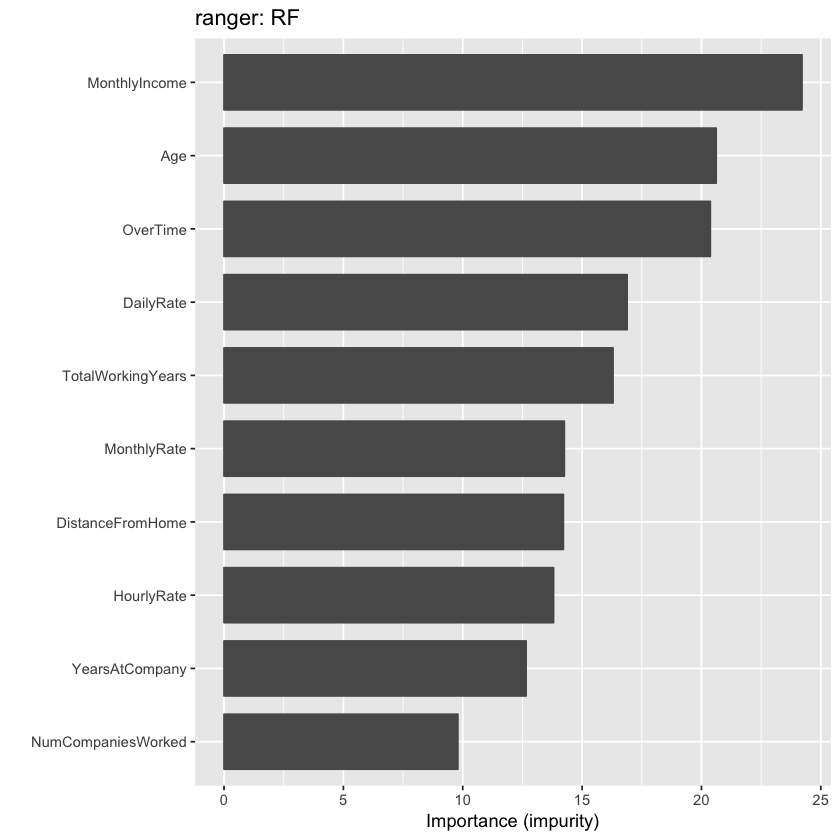

In [11]:
vip(fit.ranger) + ggtitle("ranger: RF")

We see the PDP plot for the monthly income variablethat the probability of an employee attriting decreases, on average (across all observed data), as their monthly income approaches $5,000 and then remains relatively flat.

  |======================================================================| 100%


MonthlyIncome,mean_response,stddev_response,std_error_mean_response
1009.000,0.2474949,0.2163680,0.005652937
2008.474,0.2158703,0.2287447,0.005976297
3007.947,0.1592560,0.2240314,0.005853157
4007.421,0.1512014,0.2211966,0.005779092
5006.895,0.1516519,0.2206662,0.005765235
6006.368,0.1517884,0.2217336,0.005793122
7005.842,0.1527167,0.2212566,0.005780661
8005.316,0.1548191,0.2221931,0.005805129
9004.789,0.1569215,0.2225750,0.005815105
10004.263,0.1685256,0.2206037,0.005763602


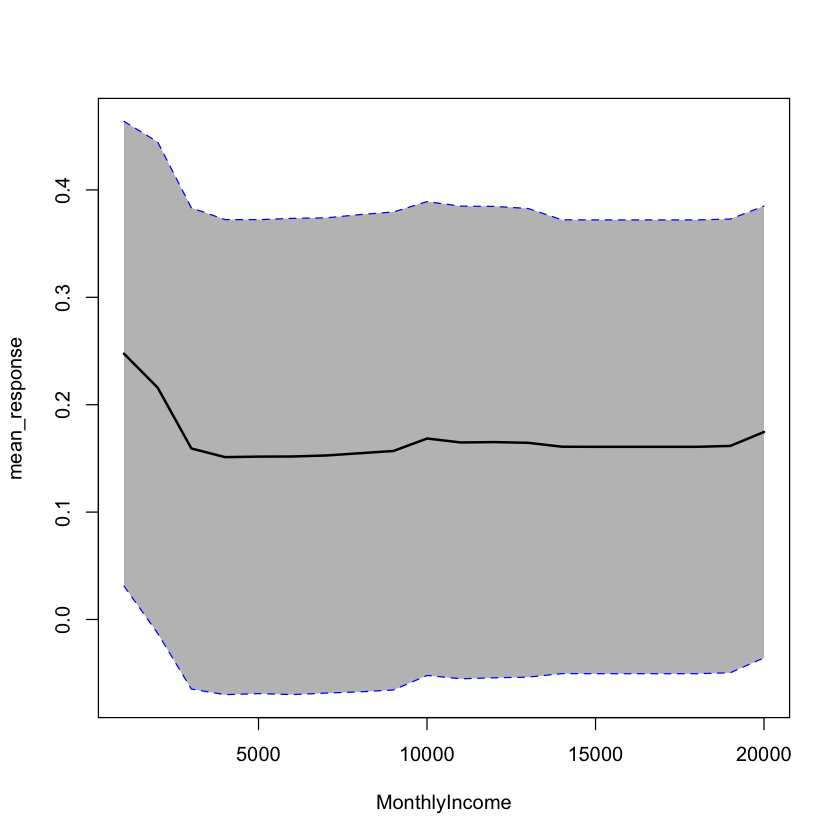

In [12]:
# built-in PDP support in H2O
h2o.partialPlot(h2o_rf, data = train_obs.h2o, cols = "MonthlyIncome")

We can gain further insight by using centered ICE curves which can help draw out further details. 

For example, the following ICE curves show a similar trend line as the PDP above but by centering we identify the decrease as monthly income approaches \\$5,000 followed by an increase in probability of attriting once an employee’s monthly income approaches $20,000. 

Futhermore, we see some turbulence in the flatlined region between $5-$20K) which means there appears to be certain salary regions where the probability of attriting changes.

Warning message:
“Ignoring unknown parameters: csides”

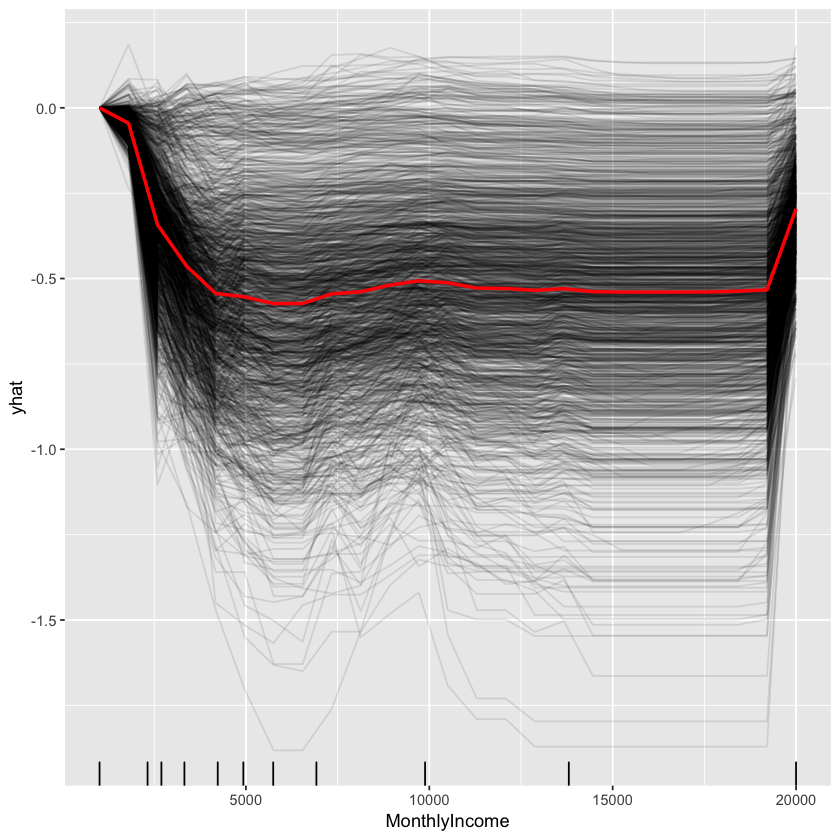

In [13]:
fit.ranger %>%
  partial(pred.var = "MonthlyIncome", grid.resolution = 25, ice = TRUE) %>%
  autoplot(rug = TRUE, train = train_obs, alpha = 0.1, center = TRUE)

These visualizations help us to understand our model from a global perspective: identifying the variables with the largest overall impact and the typical influence of a feature on the response variable across all observations. 

However, what these do not help us understand is given a new observation, what were the most influential variables that determined the predicted outcome. If the model is a regressor, the simple model will predict the output of the complex model directly. If the complex model is a classifier, the simple model will predict the probability of the chosen class(es).

### Local Interpretation

LIME provides a great, model-agnostic approach to assessing local interpretation of predictions. LIME applies a ridge regression model with the weighted permuted observations as the simple model.

In [14]:
explainer_caret <- lime(train_obs, fit.caret, n_bins = 5)

class(explainer_caret)

[1] "data_frame_explainer" "explainer"            "list"

In [15]:
explanation_caret <- explain(
  x = local_obs, 
  explainer = explainer_caret, 
  n_permutations = 5000,
  dist_fun = "gower",
  kernel_width = .75,
  n_features = 10, 
  feature_select = "highest_weights",
  labels = "Yes"
  )

In [16]:
tibble::glimpse(explanation_caret)

Observations: 50
Variables: 13
$ model_type       <chr> "classification", "classification", "classification"…
$ case             <chr> "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "2…
$ label            <chr> "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Ye…
$ label_prob       <dbl> 0.218, 0.218, 0.218, 0.218, 0.218, 0.218, 0.218, 0.2…
$ model_r2         <dbl> 0.5634135, 0.5634135, 0.5634135, 0.5634135, 0.563413…
$ model_intercept  <dbl> 0.1652389, 0.1652389, 0.1652389, 0.1652389, 0.165238…
$ model_prediction <dbl> 0.3134019, 0.3134019, 0.3134019, 0.3134019, 0.313401…
$ feature          <chr> "OverTime", "MaritalStatus", "BusinessTravel", "Depa…
$ feature_value    <int> 2, 3, 3, 3, 4, 8, 3, 2, 41, 2, 1, 2, 2, 2, 3, 7, 2, …
$ feature_weight   <dbl> 0.15056143, 0.05155023, -0.04394994, 0.03027004, -0.…
$ feature_desc     <chr> "OverTime = Yes", "MaritalStatus = Single", "Busines…
$ data             <list> [[41, Yes, Travel_Rarely, 1102, Sales, 1, College, …
$ prediction       <l

## Visualizing results

However the simplest approach to interpret the results is to visualize them. Below we create a visualization containing an individual plot for each observation (case 1, 2, …, n) in our local_obs data frame. Since we specified labels = "Yes" in the explain() function, it will provide the probability of each observation attriting. And since we specified n_features = 10 it will plot the 10 most influential variables that best explain the linear model in that observations local region and whether the variable is causes an increase in the probability (supports) or a decrease in the probability (contradicts).

Consequently, we can infer that case 3 has the highest liklihood of attriting out of the 5 observations and the 3 variables that appear to be influencing this high probability include working overtime, being single, and working as a lab tech.

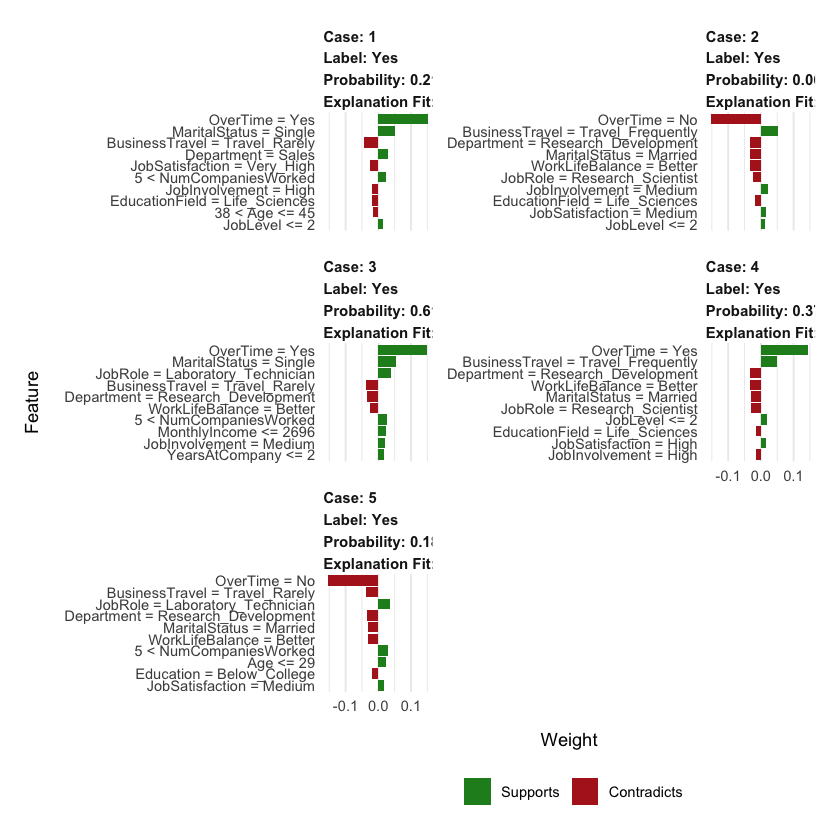

In [17]:
plot_features(explanation_caret)

The other plot we can create is a heatmap showing how the different variables selected across all the observations influence each case.

This plot becomes useful if you are trying to find common features that influence all observations or if you are performing this analysis across many observations which makes plot_features difficult to discern.

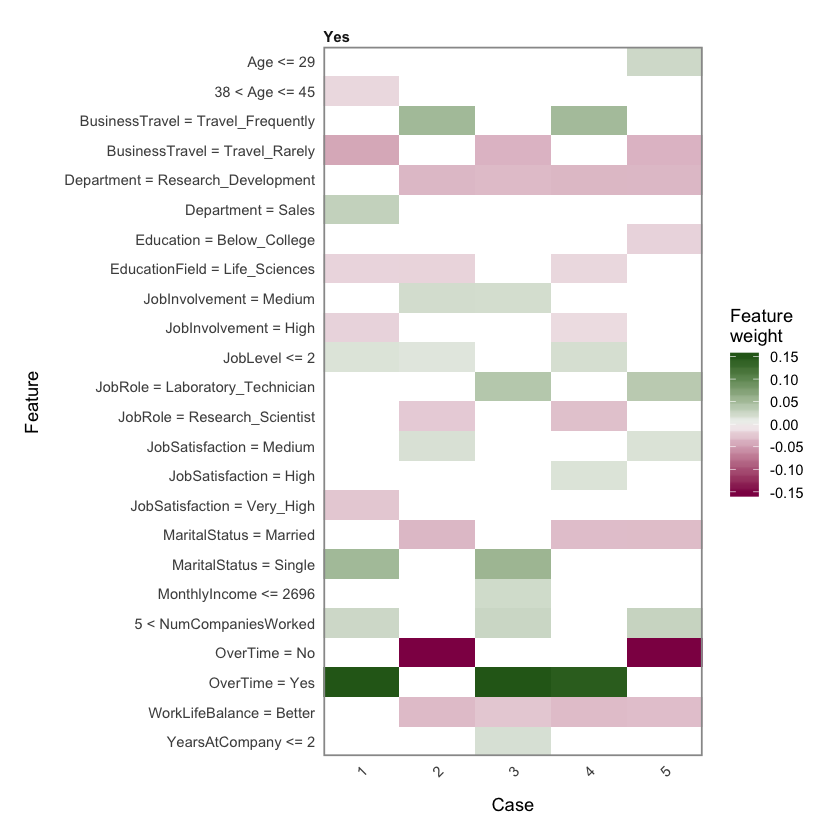

In [18]:
# Heatmap
plot_explanations(explanation_caret)

### Tuning

As you can see in the above plot_features plot, the output provides the model fit. In this case the best simple model fit for the given local regions was $Rˆ{2}$ = 0.59 for case 3. Considering there are several knobs we can turn when performing the LIME algorithm, we can treat these as tuning parameters to try find the best fit model for the local region. This helps us to maximize the amount of trust we can have in the local region explanation.

In [19]:
# tune LIME algorithm
explanation_caret <- explain(
  x = local_obs, 
  explainer = explainer_caret, 
  n_permutations = 5000,
  dist_fun = "manhattan", # manhattan distance algorithm
  kernel_width = 3,
  n_features = 10, 
  feature_select = "lasso_path", #  LARS lasso model.
  labels = "Yes"
  )

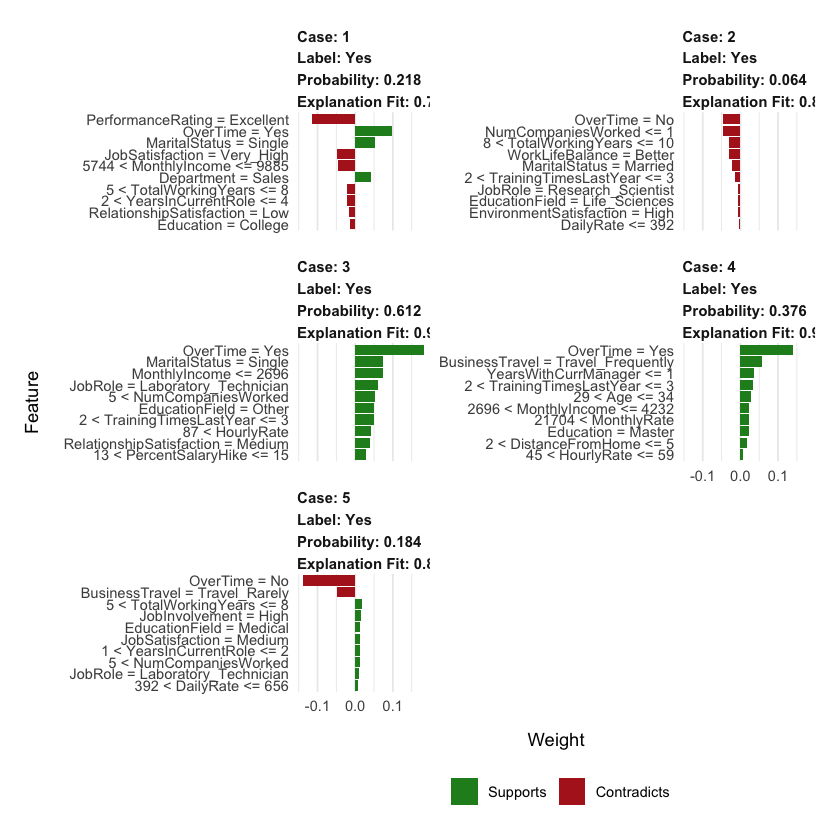

In [20]:
plot_features(explanation_caret)

In [21]:
explainer_h2o_rf  <- lime(train_obs, h2o_rf, n_bins = 5)
explainer_h2o_glm <- lime(train_obs, h2o_glm, n_bins = 5)
explainer_h2o_gbm <- lime(train_obs, h2o_gbm, n_bins = 5)

In [22]:
explanation_rf <- explain(local_obs, explainer_h2o_rf, n_features = 5, 
                          labels = "Yes", kernel_width = .1, 
                          feature_select = "highest_weights")
explanation_glm <- explain(local_obs, explainer_h2o_glm, n_features = 5, 
                           labels = "Yes", kernel_width = .1, 
                           feature_select = "highest_weights")
explanation_gbm <- explain(local_obs, explainer_h2o_gbm, n_features = 5, 
                           labels = "Yes", kernel_width = .1, 
                           feature_select = "highest_weights")

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [113]:
p1 <- plot_features(explanation_rf, ncol = 1) + ggtitle("rf")  
p2 <- plot_features(explanation_glm, ncol = 1) + ggtitle("glm") 
p3 <- plot_features(explanation_gbm, ncol = 1) + ggtitle("gbm") 

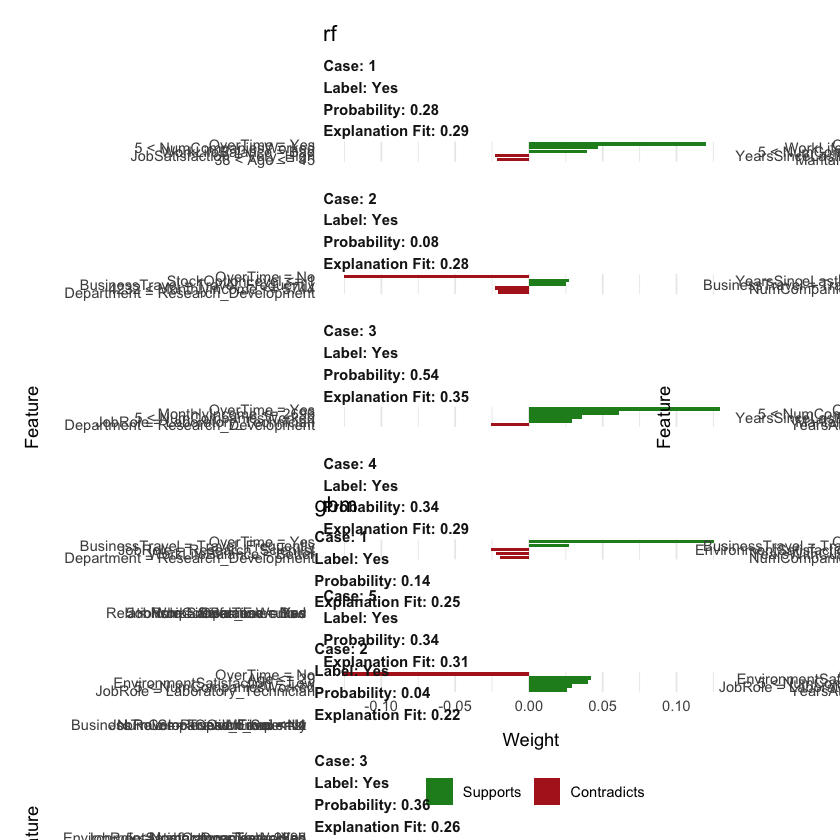

In [114]:
gridExtra::grid.arrange(p1,  p2, p3, nrow = 2, heights=c(1000,0.00001), widths=c(10,1))

In [115]:
# get the model class
class(fit.ranger)

[1] "ranger"

We can work with this pretty easily by building two functions that make lime compatible with an unsupported package. First, we need to create a model_type function that specifies what type of model this unsupported package is using. model_type is a lime specific function, we just need to create a ranger specific method. We do this by taking the class name for our ranger object and creating the model_type.ranger method and simply return the type of model (“classification” for this example).

In [116]:
# need to create custom model_type function
model_type.ranger <- function(x, ...) {
  # Function tells lime() what model type we are dealing with
  # 'classification', 'regression', 'survival', 'clustering', 'multilabel', etc
  
  return("classification")
}

In [117]:
model_type(fit.ranger)

[1] "classification"

We then need to create a predict_model method for ranger as well. The output for this function should be a data frame. For a regression problem it should produce a single column data frame with the predicted response and for a classification problem it should create a column containing the probabilities for each categorical class (binary “Yes” “No” in this example).

In [118]:
# need to create custom predict_model function
predict_model.ranger <- function(x, newdata, ...) {
  # Function performs prediction and returns data frame with Response
  pred <- predict(x, newdata)
  return(as.data.frame(pred$predictions))
}

In [119]:
predict_model(fit.ranger, newdata = local_obs)

Yes,No
0.29223968,0.7077603
0.08163651,0.9183635
0.41440714,0.5855929
0.31056825,0.6894317
0.23669841,0.7633016


In [120]:
explainer_ranger <- lime(train_obs, fit.ranger, n_bins = 5)
explanation_ranger <- explain(local_obs, explainer_ranger, n_features = 5, n_labels = 2, kernel_width = .1)

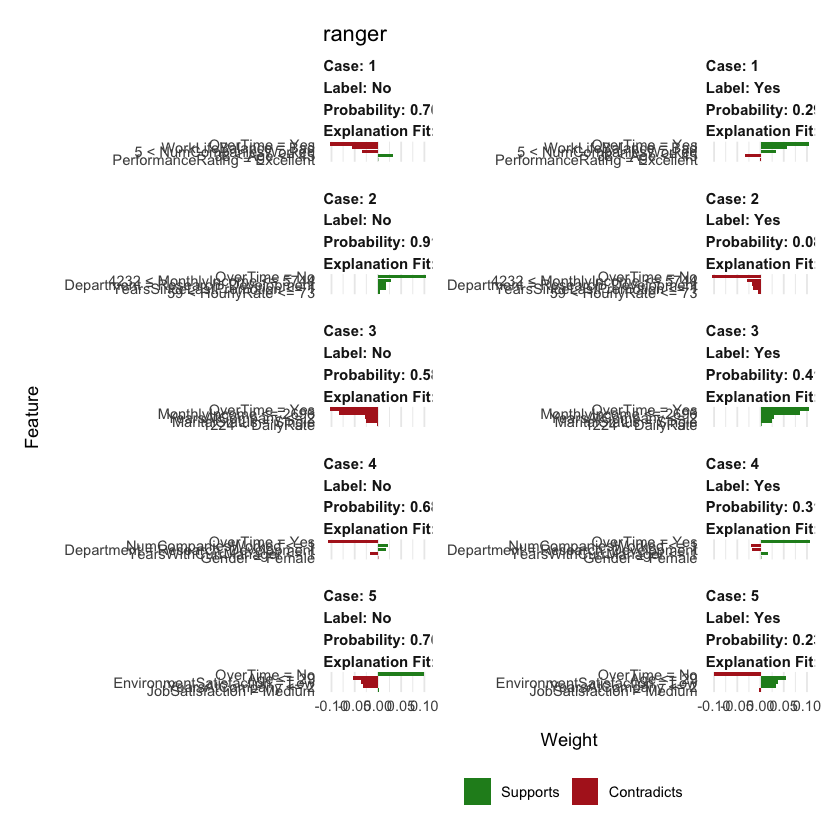

In [128]:
plot_features(explanation_ranger, ncol = 2) + ggtitle("ranger")